# Melissa CHIRPS-GEFS

In [42]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import ocha_stratus as stratus
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
from tqdm.auto import tqdm
from dask.diagnostics import ProgressBar

from src.datasources import ibtracs, codab, chirps_gefs
from src.datasources.ibtracs import knots2cat
from src.constants import *

In [5]:
blob_name = f"{PROJECT_PREFIX}/processed/fcast_obsv_combined_stats.parquet"
df_stats = stratus.load_parquet_from_blob(blob_name)

In [10]:
adm0 = codab.load_codab_from_blob()

<Axes: >

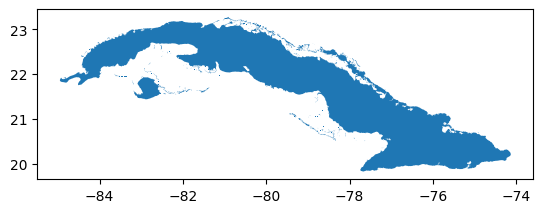

In [11]:
adm0.plot()

In [45]:
issued_date = datetime(2025, 10, 26).date()

das = []
for lt in tqdm(range(16)):
    valid_date = issued_date + pd.Timedelta(days=lt)
    da_in = chirps_gefs.open_chirps_gefs(issued_date, valid_date)
    da_in["valid_date"] = valid_date
    das.append(da_in)

  0%|          | 0/16 [00:00<?, ?it/s]

In [46]:
da_gefs = xr.concat(das, dim="valid_date").squeeze(drop=True)

In [47]:
total_bounds = adm0.total_bounds

In [48]:
da_gefs_clip_box = da_gefs.rio.clip_box(*total_bounds)

In [49]:
with ProgressBar():
    da_gefs_clip_box_computed = da_gefs_clip_box.compute()

[########################################] | 100% Completed | 263.45 s


In [50]:
da_gefs_clip = da_gefs_clip_box_computed.rio.clip(adm0.geometry)

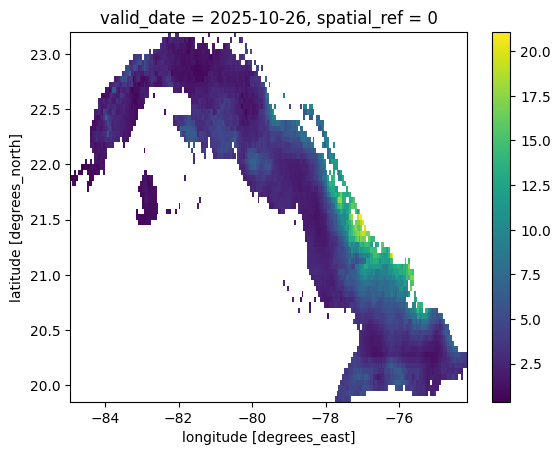

In [51]:
da_gefs_clip.isel(valid_date=0).plot()

In [52]:
da_gefs_q80 = da_gefs_clip.quantile(q=0.8, dim=["x", "y"])

In [53]:
da_gefs_roll2 = da_gefs_clip.rolling(valid_date=2).sum()

In [54]:
da_gefs_q80 = da_gefs_roll2.quantile(q=0.8, dim=["x", "y"])

/Users/tdowning/.pyenv/versions/ds-aa-cub-hurricanes/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [55]:
da_gefs_q80.max()

<xarray.DataArray ()> Size: 4B
array(91.454346, dtype=float32)
Coordinates:
    quantile  float64 8B 0.8

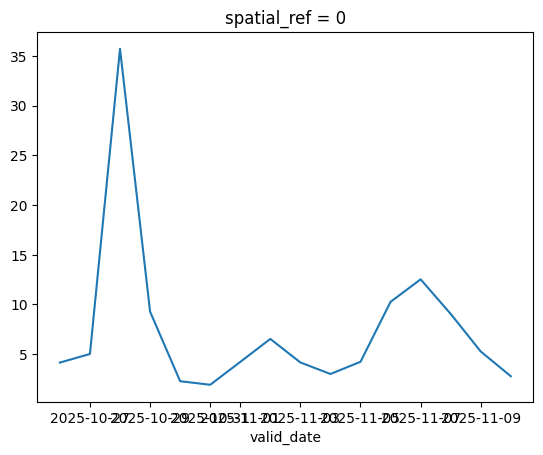

In [56]:
da_gefs_clip.mean(dim=["x", "y"]).plot()